In [133]:
import numpy as np
import pandas as pd
import sklearn

import cv2
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch.cuda.amp import GradScaler, autocast
import torchvision as tv

import os
from os import listdir
from os.path import isfile, join

import wandb
import gc
from tqdm.notebook import tqdm
import ipywidgets as widgets

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [134]:
VERSION = 'resNext50'
BATCH_SIZE = 32
MAX_TRAIN_BATCHES = 613 // BATCH_SIZE
MAX_VAL_BATCHES = 72 // BATCH_SIZE
MAX_TEST_BATCHES = 315 // BATCH_SIZE
IMAGE_SIZE = (200,150)
MAX_LR = 0.0015
NB_EPOCHS = 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_MODEL = True
print(DEVICE)

cuda


In [135]:
torch.cuda.empty_cache()

In [136]:
dataset_types = ['train','valid','test']

images_lists = {}
for dataset_type in dataset_types:
    for cancer_type in ['adenocarcinoma','large_cell_carcinoma','normal','squamous_cell_carcinoma']:
        images_lists[f'{dataset_type}_{cancer_type}_images'] = [f'C:\\Users\\galse\\DS50_SAMBA\\images\\{dataset_type}\\{cancer_type}\\{i}' 
                                                                for i in listdir(f'C:\\Users\\galse\\DS50_SAMBA\\images\\{dataset_type}\\{cancer_type}')]
        print(f"Taille du dataset {dataset_type}_{cancer_type}_images : {len(images_lists[f'{dataset_type}_{cancer_type}_images'])}")

# We can see that the datasets are balanced

Taille du dataset train_adenocarcinoma_images : 195
Taille du dataset train_large_cell_carcinoma_images : 115
Taille du dataset train_normal_images : 148
Taille du dataset train_squamous_cell_carcinoma_images : 155
Taille du dataset valid_adenocarcinoma_images : 23
Taille du dataset valid_large_cell_carcinoma_images : 21
Taille du dataset valid_normal_images : 13
Taille du dataset valid_squamous_cell_carcinoma_images : 15
Taille du dataset test_adenocarcinoma_images : 120
Taille du dataset test_large_cell_carcinoma_images : 51
Taille du dataset test_normal_images : 54
Taille du dataset test_squamous_cell_carcinoma_images : 90


In [137]:
dataframes = {}
for dataset_type in dataset_types:
    dataframes[f'{dataset_type}'] = pd.DataFrame(columns=['image_id','label'])
    dataframes[f'{dataset_type}']['image_id'] = images_lists[f'{dataset_type}_adenocarcinoma_images'] + images_lists[f'{dataset_type}_large_cell_carcinoma_images'] + images_lists[f'{dataset_type}_normal_images'] + images_lists[f'{dataset_type}_squamous_cell_carcinoma_images']
    
    dataframes[f'{dataset_type}']['label'] = np.zeros_like(images_lists[f'{dataset_type}_adenocarcinoma_images'],dtype=int).tolist()+np.ones_like(images_lists[f'{dataset_type}_large_cell_carcinoma_images'],dtype=int).tolist()+np.full_like(images_lists[f'{dataset_type}_normal_images'],2,dtype=int).tolist()+np.full_like(images_lists[f'{dataset_type}_squamous_cell_carcinoma_images'],3,dtype=int).tolist()

In [138]:
dataframes['train'].head()

,image_id,label
0,C:\Users\galse\DS50_SAMBA\images\train\adenoca...,0
1,C:\Users\galse\DS50_SAMBA\images\train\adenoca...,0
2,C:\Users\galse\DS50_SAMBA\images\train\adenoca...,0
3,C:\Users\galse\DS50_SAMBA\images\train\adenoca...,0
4,C:\Users\galse\DS50_SAMBA\images\train\adenoca...,0


In [139]:
print(len(dataframes['train']),len(dataframes['valid']),len(dataframes['test']))

613 72 315


In [140]:
dataframes['valid'].head(15)

,image_id,label
0,C:\Users\galse\DS50_SAMBA\images\valid\adenoca...,0
1,C:\Users\galse\DS50_SAMBA\images\valid\adenoca...,0
2,C:\Users\galse\DS50_SAMBA\images\valid\adenoca...,0
3,C:\Users\galse\DS50_SAMBA\images\valid\adenoca...,0
4,C:\Users\galse\DS50_SAMBA\images\valid\adenoca...,0
5,C:\Users\galse\DS50_SAMBA\images\valid\adenoca...,0
6,C:\Users\galse\DS50_SAMBA\images\valid\adenoca...,0
7,C:\Users\galse\DS50_SAMBA\images\valid\adenoca...,0
8,C:\Users\galse\DS50_SAMBA\images\valid\adenoca...,0
9,C:\Users\galse\DS50_SAMBA\images\valid\adenoca...,0


In [141]:
class LungsCancerDetectionDataset(Dataset):
    def __init__(self, annotations_file,transform=None, target_transform=None):
        self.img_labels = annotations_file
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = str(self.img_labels.iloc[idx].image_id)
        image = cv2.imread(img_path)
        image = cv2.resize(image, IMAGE_SIZE)
        image = np.transpose(image, (2, 0, 1))
        image = torch.as_tensor(image)
        image = image.float()
        image = image/255
        label = torch.as_tensor(self.img_labels.iloc[idx].label)
        return image, label

In [142]:
class LungsCancerDetectionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = tv.models.resnext50_32x4d(pretrained=True)
        self.nn_detection = torch.nn.Sequential(
            torch.nn.Linear(1000,4)
        )

    def forward(self, x):
        x = self.model(x)
        logits = self.nn_detection(x)
        return logits
    
    def predict(self,logits):
        preds = self.forward(logits)
        preds = torch.sigmoid(preds)
        return preds

In [143]:
def save_model(name, model):
    torch.save(model.state_dict(), f'{name}.pt')

def load_model(model, name, path='.'):
    data = torch.load(os.path.join(path, f'{name}.pt'))
    model.load_state_dict(data)
    return model

def gc_collect():
    gc.collect()
    torch.cuda.empty_cache()

In [144]:
def train_model(ds_train, logger, name):
    
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True,drop_last=True)
    model = LungsCancerDetectionModel().to(DEVICE)
    optim = torch.optim.Adam(model.parameters())
    
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=MAX_LR, epochs=NB_EPOCHS,
                                                steps_per_epoch=min(MAX_TRAIN_BATCHES, len(dl_train)),
                                                pct_start=0.3)
    model.train()
    scaler = GradScaler()
    
    for epoch in tqdm(range(NB_EPOCHS), desc='Epoch'):
        with tqdm(dl_train, desc='Train') as progress:

            for batch_idx, (X, y) in enumerate(progress):

                if batch_idx >= MAX_TRAIN_BATCHES:
                    save_model(name, model)
                    break

                optim.zero_grad()
                with autocast():
                    pred = model.forward(X.to(DEVICE))
                    pred = pred.squeeze()
                    loss = torch.nn.functional.cross_entropy(pred,y.to(DEVICE))

                    if np.isinf(loss.item()) or np.isnan(loss.item()):
                        print(f'Bad loss, skipping the batch {batch_idx}')
                        del loss, pred
                        gc_collect()
                        continue

                scaler.scale(loss).backward()
                scaler.step(optim)
                scaler.update()
                scheduler.step()

                logger.log({'training loss': (loss.item()),
                            'learning rate': scheduler.get_last_lr()[0],
                            'epoch': epoch})
                
    save_model(name, model)
    return model

In [145]:
if TRAIN_MODEL == True :
    with wandb.init(project='DS50', name=VERSION) as run:
        gc_collect()
        ds_train = LungsCancerDetectionDataset(dataframes['train'])
        model = train_model(ds_train,run,VERSION)
else:
    model = load_model(LungsCancerDetectionModel().to(DEVICE),"DenseNet_V2")

c:\Users\galse\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\galse\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

c:\Users\galse\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train:   0%|          | 0/19 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

Train:   0%|          | 0/19 [00:00<?, ?it/s]

epoch,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆██████████
learning rate,▁▁▂▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁
training loss,█▇▇▅▄▅▃▄▅█▃▇▃▃▄▄▆▃▄▅▂▃▃▃▃▃▃▂▂▂▂▂▂▄▁▂▁▁▂▂
epoch,3
learning rate,0.0
training loss,0.20664


In [146]:
def evaluate_model(model, ds, max_batches):
    model = model.to(DEVICE)
    dl_val = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False,drop_last=True)
    preds = []
    labels = []
    with torch.no_grad():
        model.eval()
        losses = []
        with tqdm(dl_val, desc='Val') as progress:
            for i, (X, y) in enumerate(progress):
                with autocast():
                    pred = model.forward(X.to(DEVICE))
                    pred = pred.squeeze()
                    loss = torch.nn.functional.cross_entropy(pred,y.to(DEVICE))
                    pred = torch.sigmoid(pred)
                    preds.append(pred.cpu())
                    losses.append(loss.cpu())
                    labels.append(y.cpu().numpy())
                    
                if i >= max_batches:
                    break
        preds = torch.concat(preds).cpu().numpy()
        labels = np.concatenate(labels)
        return np.mean(losses), preds

Val:   0%|          | 0/2 [00:00<?, ?it/s]

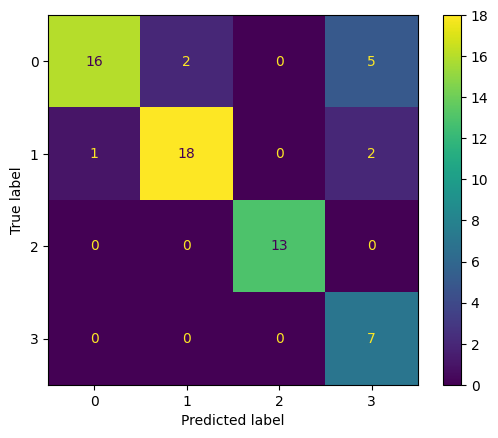

Accuracy on valid dataset :  0.84375


Val:   0%|          | 0/9 [00:00<?, ?it/s]

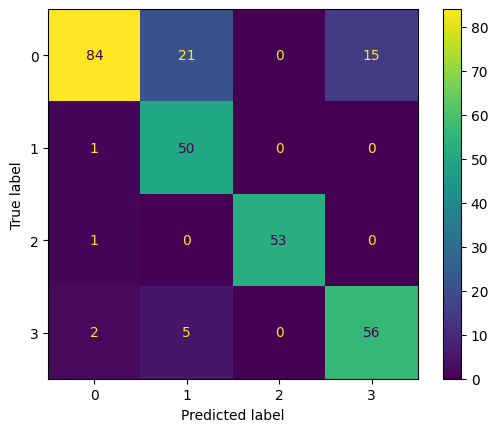

Accuracy on test dataset :  0.84375


In [147]:
def make_predictions(model,dataset_type, max_batches):
    ds_eval = LungsCancerDetectionDataset(dataframes[dataset_type])
    loss, y_pred = evaluate_model(model, ds_eval, max_batches)
    y_pred = pd.DataFrame(data=y_pred,columns=['0','1','2','3'])
    y_pred = y_pred.idxmax(axis=1).to_numpy(dtype='float32')
    cm = confusion_matrix(dataframes[dataset_type]['label'].head(len(y_pred)),y_pred)
    disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp_cm.plot()
    plt.show()

    correct_predictions = cm.diagonal().sum()
    total_samples = cm.sum()
    accuracy = correct_predictions / total_samples
    print(f"Accuracy on {dataset_type} dataset : ", accuracy)
    return accuracy
    
val_accuracy = make_predictions(model,'valid',MAX_VAL_BATCHES)
test_accuracy = make_predictions(model,'test',MAX_TEST_BATCHES)

In [148]:
f = open("resultats_resNext50.txt", "a")

f.write("VERSION " + VERSION + "\n")
f.write("MAX_LR "+ str(MAX_LR) + "\n")
f.write("BATCH_SIZE " + str(BATCH_SIZE) + "\n")
f.write("IMAGE_SIZE " + str(IMAGE_SIZE) + "\n")
f.write("NB_EPOCHS " + str(NB_EPOCHS) + "\n")
f.write("VAL ACCURACY " + str(val_accuracy) + "\n")
f.write("TEST ACCURACY " + str(test_accuracy) + "\n\n")

f.close()